In [1]:
import warnings
import sys 
import os    
from statesegmentation import GSBS
from functools import reduce
import numpy as np
from brainiak.eventseg.event import EventSegment
import nibabel as nib
from nilearn.masking import apply_mask
from scipy.stats import zscore

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

## 0. Load Angular Gyrus data

From the angular gyrus (area PG from (Eickhoff et al., 2005), we'll load movie data from all subjects, and recall data from one subject. Subjects were watching the first hour of [A Study in Pink](https://en.wikipedia.org/wiki/A_Study_in_Pink) (here we are loading only the first half of this data), and then freely recalled the narrative. Please refer to [Chen et al. (2017)](https://doi.org/10.1038/nn.4450) to learn more about this dataset. 

In [2]:
if (not os.path.exists('Sherlock_AG_movie.npy') or
    not os.path.exists('Sherlock_AG_recall.npy')):
    Sherlock_path = '../../Sherlock/'
    movie = []

    print('Cached data not found, loading from nii files')
    for sub in range(1,17):
        print('   Loading sub-%02d...' % sub)
        movie.append(apply_mask(os.path.join(Sherlock_path, 'fmriprep','sub-%02d' % sub, 'func', \
                               'sub-%02d_denoise_smooth6mm_task-sherlockPart1_AngOnly_bold.nii.gz' % sub),
                               os.path.join(Sherlock_path, 'AG_mask.nii.gz')))
        if sub == 7:
            recall = apply_mask(os.path.join(Sherlock_path, 'fmriprep','sub-%02d' % sub, 'func', \
                               'sub-%02d_denoise_smooth6mm_task-freerecall_AngOnly_bold.nii.gz' % sub),
                               os.path.join(Sherlock_path, 'AG_mask.nii.gz'))

    valid_vox = reduce(np.union1d, [np.where(np.std(m, axis=0)>0)[0] for m in movie])
    movie = [m[:,valid_vox] for m in movie]
    recall = recall[:487,valid_vox]  # Recall of 1st half of movie takes 487 TRs 
    np.save('Sherlock_AG_movie.npy', movie)
    np.save('Sherlock_AG_recall.npy', recall)

    
movie = np.load('Sherlock_AG_movie.npy')
recall = np.load('Sherlock_AG_recall.npy')
movie_group = np.mean(movie, axis=0)

## 1. Finding event boundaries during perception

### 1.0 Event structure in activity patterns

Before applying any model, a good first step is to plot the correlation between activity patterns for each pair of timepoints during the movie. In this dataset, this shows blocks along the diagonal, which indicates that activity patterns are remaining stable for periods of tens of timepoints. This is the kind of structure that the HMM and GBSS models will be looking for.

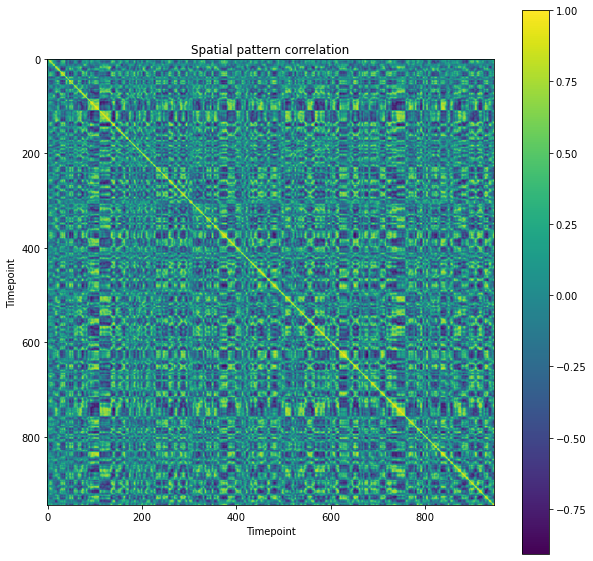

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(np.corrcoef(movie_group))
plt.xlabel('Timepoint')
plt.ylabel('Timepoint')
plt.colorbar()
plt.title('Spatial pattern correlation');

### 1.1 Fitting the HMM

To use an HMM to find both the event timings and the patterns corresponding to each event, we can use the EventSegment class from the brainiak toolbox. We need to specify the number of events, which here we set to 29 (corresponding to the number of boundaries typically annotated by human subjects).

In [4]:
movie_HMM = EventSegment(n_events = 29)
movie_HMM.fit(movie_group);

This fit produces:
* The log-likelihood (measuring overall model fit) over training. (Note that the log-likelihood on held-out test data is often a better measure of model quality - see below).
* The mean voxel pattern for each event. Here we show only 1% of the voxels since the ROI is large.
* A matrix showing the probability of being in each event at each timepoint. We can use this to derive the most likely timepoints where boundaries occur, and plot these on top of the timepoint similarity matrix for comparison.

Text(0.5, 0, 'Model fitting steps')

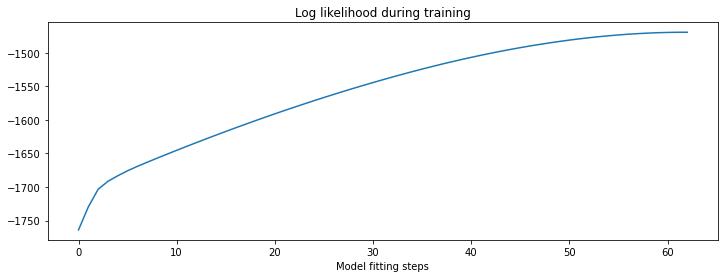

In [5]:
# Plotting the log-likelihood (measuring overall model fit)
plt.figure(figsize = (12, 4))
plt.plot(movie_HMM.ll_)
plt.title('Log likelihood during training')
plt.xlabel('Model fitting steps')

Text(0, 0.5, 'Voxels')

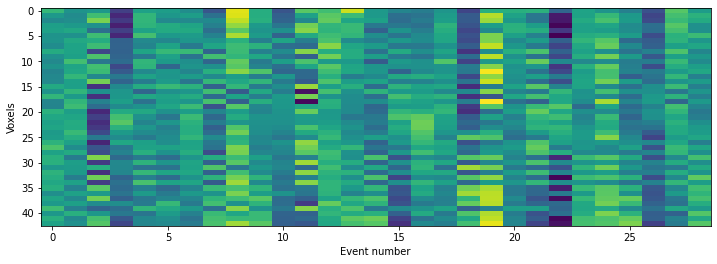

In [6]:
# Plotting mean activity in each event for some example voxels
plt.figure(figsize = (12, 4))
example_vox = np.arange(0,movie_HMM.event_pat_.shape[0],100)
plt.imshow(movie_HMM.event_pat_[example_vox,:], aspect='auto')
plt.xlabel('Event number')
plt.ylabel('Voxels')

Text(0.5, 1.05, 'Event probability')

<Figure size 864x432 with 0 Axes>

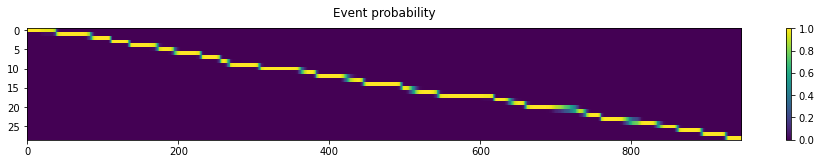

In [7]:
# Plot probability of being in each event at each timepoint
plt.figure(figsize = (12, 6))
plt.matshow(movie_HMM.segments_[0].T, aspect='auto')
plt.gca().xaxis.tick_bottom()
plt.colorbar()
plt.title('Event probability')

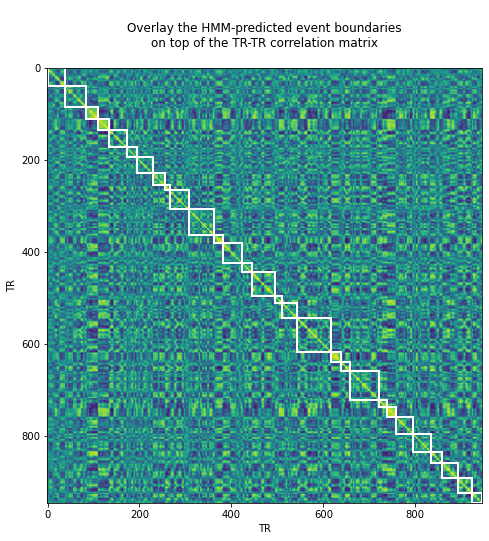

In [8]:
# Identify event boundaries as timepoints when max probability switches events
event_bounds = np.where(np.diff(np.argmax(movie_HMM.segments_[0], axis = 1)))[0]
nTRs = movie_group.shape[0]


# Plot boundaries as boxes on top of timepoint correlation matrix
def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text):
    
    ax.imshow(np.corrcoef(data_matrix), cmap = 'viridis')
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    
    # plot the boundaries 
    bounds_aug = np.concatenate(([0], bounds, [n_TRs]))
    
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i+1] - bounds_aug[i],
            bounds_aug[i+1] - bounds_aug[i],
            linewidth = 2, edgecolor = 'w',facecolor = 'none'
        )
        ax.add_patch(rect)


f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = '''
Overlay the HMM-predicted event boundaries
on top of the TR-TR correlation matrix
'''
plot_tt_similarity_matrix(ax, movie_group, event_bounds, nTRs, title_text)

### 1.2 Determining the number of events with the HMM

What if we don't want to prespecify the number of events, but instead want to determine the number of events from the data? One way to determine the best number of events is to fit the model on a training set and then test the model fit on independent subjects.

(In this example, the training and test sets are the same size, so their variances should be similar. If the test set is smaller than the training set, you should pass a different variance value to find_events(). For example, calc_weighted_event_var() can be used to estimate the variance within a matched-sized subset of the training set.)

In [9]:
k_array = np.arange(20, 61, 10)
test_ll = np.zeros(len(k_array))

for i, k in enumerate(k_array):
    print('Trying %d events' % k)
    
    print('   Fitting model on training subjects...')
    movie_train = np.mean(movie[:8], axis = 0)
    movie_HMM = EventSegment(k)
    movie_HMM.fit(movie_train)
    
    print('   Testing model fit on held-out subjects...')
    movie_test = np.mean(movie[8:], axis = 0)
    _, test_ll[i] = movie_HMM.find_events(movie_test)

Trying 20 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 30 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 40 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 50 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 60 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...


Text(0.5, 0, 'Average event length (sec)')

/Users/chrisb/anaconda3/envs/OHBM/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


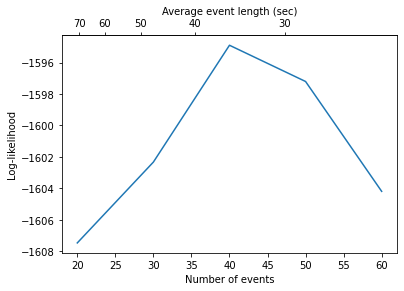

In [10]:
plt.plot(k_array, test_ll)
plt.xlabel('Number of events')
plt.ylabel('Log-likelihood')

movie_dur = nTRs * 1.5  # Data acquired every 1.5 seconds
secax = plt.gca().secondary_xaxis('top', functions=(lambda x: movie_dur / x, lambda x: movie_dur / x))
secax.set_xlabel('Average event length (sec)')

### 1.3 Finding event boundaries with GSBS

In [11]:
%%time

GSBS_states = GSBS(x = movie_group, kmax = 20)
GSBS_states.fit()

GSBS_bounds = np.where(GSBS_states.bounds)[0]

CPU times: user 12min 34s, sys: 1min 31s, total: 14min 5s
Wall time: 14min 12s


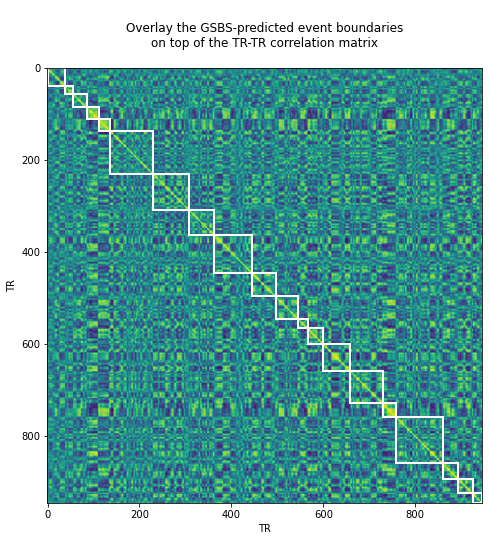

In [12]:
f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = '''
Overlay the GSBS-predicted event boundaries
on top of the TR-TR correlation matrix
'''
plot_tt_similarity_matrix(ax, movie_group, GSBS_bounds, nTRs, title_text)

## 2. Comparing model and human-labeled boundaries

We can also compare the event boundaries between different models, or between a model to human-labeled event boundaries. Because there is some ambiguity in both the stimulus and the model about exactly which timepoint the transition occurs at, we will count two boundaries as being a "match" if they are within 3 TRs (4.5 seconds) of each other.

To determine whether the match is statistically significant, we generate permuted versions of the boundaries as a null model for comparison.

In [13]:
human_bounds = [
    26, 35, 56, 72, 86, 108, 131, 143, 157, 173, 192, 204, 
    226, 313, 362, 398, 505, 526, 533, 568, 616, 634, 678,
    696, 747, 780, 870, 890
]

We'll generate two versions of HMM boundaries using 40 events (since 40 events maximized the test log-likelihood in 1.2 above). In addition to the "vanilla" HMM, we'll run an HMM with more flexibility during fitting (allowing for split-merge operations). This is slower (and so should usually only be used for generating a final segmentation), but can produce better fits if [events are very uneven in duration](http://www.chrisbaldassano.com/blog/2020/05/19/splitmerge/).

In [14]:
print('Fitting HMM with 40 events...')
HMM40 = EventSegment(n_events = 40)
HMM40.fit(movie_group)
HMM40_bounds = np.where(np.diff(np.argmax(HMM40.segments_[0], axis = 1)))[0]

print('Fitting split-merge HMM with 40 events...')
HMM40_SM = EventSegment(n_events = 40, split_merge = True)
HMM40_SM.fit(movie_group)
HMM40_SM_bounds = np.where(np.diff(np.argmax(HMM40_SM.segments_[0], axis = 1)))[0]

Fitting HMM with 40 events...
Fitting split-merge HMM with 40 events...


Matches to Human bounds: HMM=0.535714, HMM_SM=0.571429, GSBS=0.214286


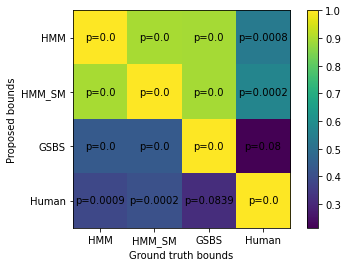

In [15]:
# Computes fraction of "ground truth" bounds are covered by a set of proposed bounds
def frac_match(proposed_bounds, gt_bounds, num_TRs):
    nPerm = 10000
    threshold = 3
    np.random.seed(0)

    gt_lengths = np.diff(np.concatenate(([0],gt_bounds,[num_TRs])))
    match = np.zeros(nPerm + 1)
    for p in range(nPerm + 1):
        gt_bounds = np.cumsum(gt_lengths)[:-1]
        for b in gt_bounds:
            if np.any(np.abs(proposed_bounds - b) <= threshold):
                match[p] += 1
        match[p] /= len(gt_bounds)
        gt_lengths = np.random.permutation(gt_lengths)
    
    return match[0], (match[0] < match[1:]).mean()

bound_types = [HMM40_bounds, HMM40_SM_bounds, GSBS_bounds, human_bounds]
b_match = np.zeros((len(bound_types), len(bound_types)))
b_match_p = np.zeros((len(bound_types), len(bound_types)))
for i, b1 in enumerate(bound_types):
    for j, b2 in enumerate(bound_types):
        b_match[i,j], b_match_p[i,j] = frac_match(b1, b2, nTRs)


plt.imshow(b_match)
plt.colorbar()
plt.xticks(np.arange(4), ['HMM', 'HMM_SM', 'GSBS', 'Human'])
plt.yticks(np.arange(4), ['HMM', 'HMM_SM', 'GSBS', 'Human'])
plt.xlabel('Ground truth bounds')
plt.ylabel('Proposed bounds')
for (j,i),label in np.ndenumerate(b_match_p):
    plt.text(i,j,'p='+str(label),ha='center',va='center')

print('Matches to Human bounds: HMM=%f, HMM_SM=%f, GSBS=%f' % tuple(b_match[:3,3].tolist()))

## 3. Aligning movie and recall data

A simple model of free recall is that a subject will revisit the same sequence of events experienced during perception, but the lengths of the events will not be identical between perception and recall.

### 3.1. Fit HMM on the two datasets  simultaneously

We use the same fit function as for a single dataset, but now we pass in both the movie and recall datasets in a list. We assume the two datasets have shared event transitions.

In [16]:
movie_recall_HMM = EventSegment(40)
movie_recall_HMM.fit([movie_group, recall]);

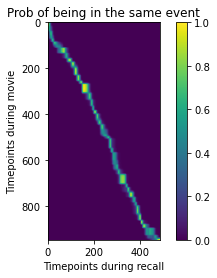

In [17]:
plt.imshow(movie_recall_HMM.segments_[0] @ movie_recall_HMM.segments_[1].T)
plt.xlabel('Timepoints during recall')
plt.ylabel('Timepoints during movie')
plt.colorbar()
plt.title('Prob of being in the same event');

### 3.2 Define events from movie, find in recall

Alternatively, rather than finding events simultaneously in the movie and recall, we can first identify events using the movie data only, and then go looking for this fixed set of events in the recall. In this case we can use non-HMM methods such as GSBS to identify the events in the movie, and then use the HMM to transfer these events to the recall.

In [18]:
n_events = np.max(GSBS_states.states)
event_pat = np.zeros((movie_group.shape[1], n_events))
for ev in range(1, n_events+1):
    event_pat[:,ev-1] = np.mean(movie_group[GSBS_states.states == ev, :], axis=0)

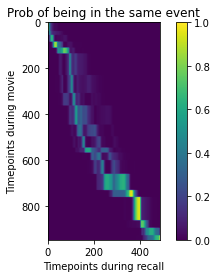

In [19]:
HMM = EventSegment(n_events)
HMM.set_event_patterns(event_pat)
#ev_var = movie_HMM.calc_weighted_event_var(movie_group, WEIGHTS, movie_HMM.event_pat_)
recall_events = HMM.find_events(recall, var = 1)[0]

movie_events = np.zeros((nTRs, n_events))
movie_events[np.arange(nTRs), GSBS_states.states-1] = 1

plt.imshow(movie_events @ recall_events.T)
plt.xlabel('Timepoints during recall')
plt.ylabel('Timepoints during movie')
plt.colorbar()
plt.title('Prob of being in the same event');